In [1]:
import pandas as pd

import numpy as np

import sklearn

import holidays

import seaborn as sns

import lazypredict

train_df = pd.read_csv("C:/Users/pfali/Downloads/playground-series-s3e19/train.csv")
test_df = pd.read_csv("C:/Users/pfali/Downloads/playground-series-s3e19/test.csv")

#preview data
train_df.head()

train_df.describe(include='all')

,id,date,country,store,product,num_sold
count,136950.00000,136950,136950,136950,136950,136950.000000
unique,NaN,1826,5,3,5,NaN
top,NaN,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,NaN
freq,NaN,75,27390,45650,27390,NaN
mean,68474.50000,NaN,NaN,NaN,NaN,165.522636
std,39534.20402,NaN,NaN,NaN,NaN,183.691575
min,0.00000,NaN,NaN,NaN,NaN,2.000000
25%,34237.25000,NaN,NaN,NaN,NaN,46.000000
50%,68474.50000,NaN,NaN,NaN,NaN,98.000000
75%,102711.75000,NaN,NaN,NaN,NaN,184.000000


In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB


In [3]:
#There are 136950 IDs of transactions done within 5 countries in 3 stores. 5 unique products were bought. No missing values.
#Data types:
#-	Id – numerical feature
#-	Date – categorical feature
#-	Country – categorical feature
#-	Store – categorical feature
#-	Product – categorical feature
#-	Num_sold – numerical feature (target)

#We will convert Country, Store and Product into numerical features. Date includes five years from 2017 to 2021. It should be determined whether the weekday or holiday correlate with the number of sold products. To do this, new features Workday, Weekend, Is_holiday will be created.


In [4]:
#convert Country, Store, Product to numerical features

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
train_df['country'] = le.fit_transform(train_df['country'])
train_df['store'] = le.fit_transform(train_df['store'])
train_df['product'] = le.fit_transform(train_df['product'])

test_df['country'] = le.fit_transform(test_df['country'])
test_df['store'] = le.fit_transform(test_df['store'])
test_df['product'] = le.fit_transform(test_df['product'])

train_df.head()
                                       

,id,date,country,store,product,num_sold
0,0,2017-01-01,0,1,0,63
1,1,2017-01-01,0,1,1,66
2,2,2017-01-01,0,1,2,9
3,3,2017-01-01,0,1,3,59
4,4,2017-01-01,0,1,4,49


In [5]:
#convert Date to datetime and check the day of the week

train_df['date'] = pd.to_datetime(train_df['date'])
train_df['weekday'] = train_df['date'].dt.weekday
train_df['weekend']=train_df['weekday']>=5

test_df['date'] = pd.to_datetime(test_df['date'])
test_df['weekday'] = test_df['date'].dt.weekday
test_df['weekend']=test_df['weekday']>=5

#convert Weekend to a numerical feature

train_df['weekend']=le.fit_transform(train_df['weekend'])
test_df['weekend']=le.fit_transform(test_df['weekend'])

train_df.head()


,id,date,country,store,product,num_sold,weekday,weekend
0,0,2017-01-01,0,1,0,63,6,1
1,1,2017-01-01,0,1,1,66,6,1
2,2,2017-01-01,0,1,2,9,6,1
3,3,2017-01-01,0,1,3,59,6,1
4,4,2017-01-01,0,1,4,49,6,1


In [6]:
#check if Date was holiday

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

train_df["year"] = train_df["date"].dt.year
train_df["month"] = train_df["date"].dt.month
train_df["day"] = train_df["date"].dt.day
test_df["year"] = test_df["date"].dt.year
test_df["month"] = test_df["date"].dt.month
test_df["day"] = test_df["date"].dt.day

years = train_df["year"].unique().tolist()
years = test_df["year"].unique().tolist()

holiday_A = holidays.CountryHoliday("AR", years=years)
holiday_C = holidays.CountryHoliday("CA", years=years)
holiday_E = holidays.CountryHoliday("EE", years=years)
holiday_J = holidays.CountryHoliday("JP", years=years)
holiday_S = holidays.CountryHoliday("ES", years=years)

holidays_df = pd.DataFrame(columns=['date', 'AR', 'CA', 'EE', 'JP', 'ES'])

for date in pd.date_range(start='2017-01-01', end='2022-12-31'):
    ar = 1 if date in holiday_A else 0
    ca = 1 if date in holiday_C else 0
    ee = 1 if date in holiday_E else 0
    jp = 1 if date in holiday_J else 0
    es = 1 if date in holiday_S else 0
    
    holidays_df.loc[len(holidays_df)] = {"date": date, "AR": ar, "CA": ca, "EE": ee, "JP": jp, "ES": es}

train_df['is_holiday_A'] = train_df['date'].map(holidays_df.set_index('date')['AR']).astype(int)
train_df['is_holiday_C'] = train_df['date'].map(holidays_df.set_index('date')['CA']).astype(int)
train_df['is_holiday_E'] = train_df['date'].map(holidays_df.set_index('date')['EE']).astype(int)
train_df['is_holiday_J'] = train_df['date'].map(holidays_df.set_index('date')['JP']).astype(int)
train_df['is_holiday_S'] = train_df['date'].map(holidays_df.set_index('date')['ES']).astype(int)
test_df['is_holiday_A'] = test_df['date'].map(holidays_df.set_index('date')['AR']).astype(int)
test_df['is_holiday_C'] = test_df['date'].map(holidays_df.set_index('date')['CA']).astype(int)
test_df['is_holiday_E'] = test_df['date'].map(holidays_df.set_index('date')['EE']).astype(int)
test_df['is_holiday_J'] = test_df['date'].map(holidays_df.set_index('date')['JP']).astype(int)
test_df['is_holiday_S'] = test_df['date'].map(holidays_df.set_index('date')['ES']).astype(int)



In [7]:
train_df = train_df.drop(columns=['date'])
test_df = test_df.drop(columns=['date'])

<Axes: xlabel='year', ylabel='num_sold'>

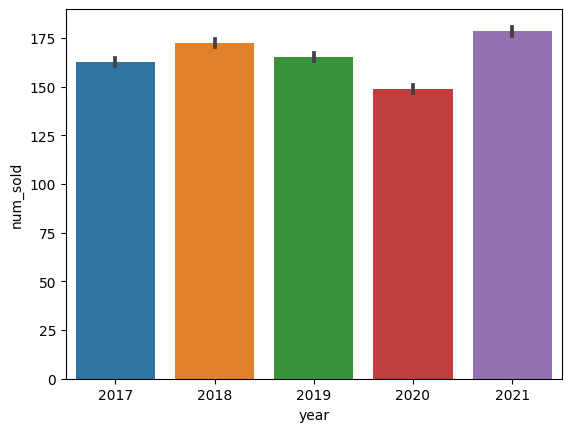

In [8]:
sns.barplot(x = 'year', y = 'num_sold', data=train_df)

#although the num_sold in 2020 is lower than in other years, it doesn't seem reasonable to exclude this year, as it is ~ 20% of data

<Axes: xlabel='weekday', ylabel='num_sold'>

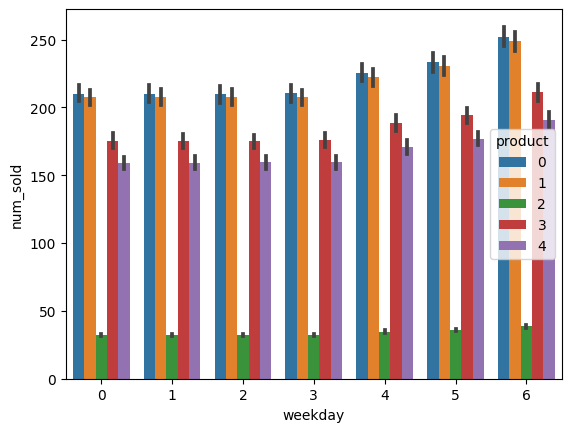

In [9]:
sns.barplot(x = 'weekday', y = 'num_sold', hue='product', data=train_df)

#for all products the num_sold is correlated with the weekday, so it seems it was a good decision to create this feature

<Axes: xlabel='is_holiday_A', ylabel='num_sold'>

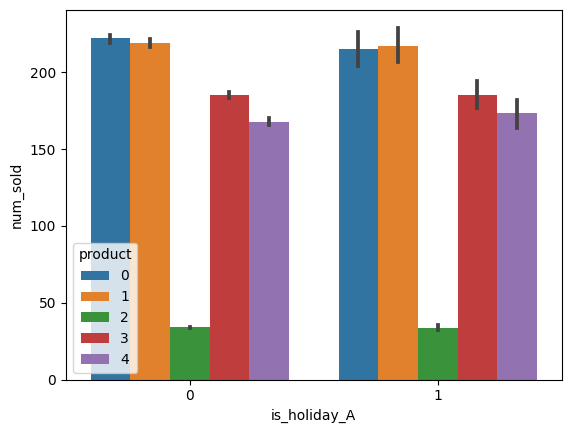

In [19]:
sns.barplot(x = 'is_holiday_A', y = 'num_sold', hue='product', data=train_df)


<Axes: xlabel='is_holiday_C', ylabel='num_sold'>

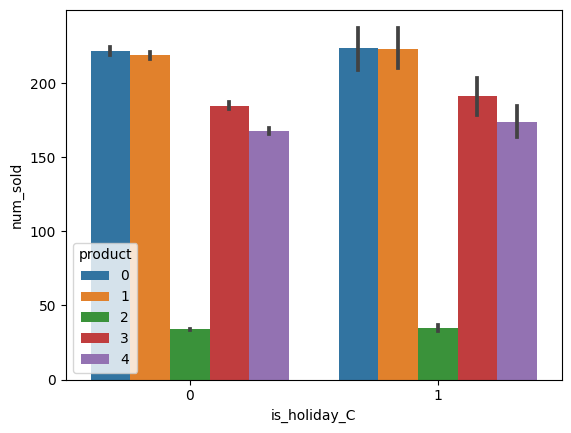

In [20]:
sns.barplot(x = 'is_holiday_C', y = 'num_sold', hue='product', data=train_df)

<Axes: xlabel='is_holiday_E', ylabel='num_sold'>

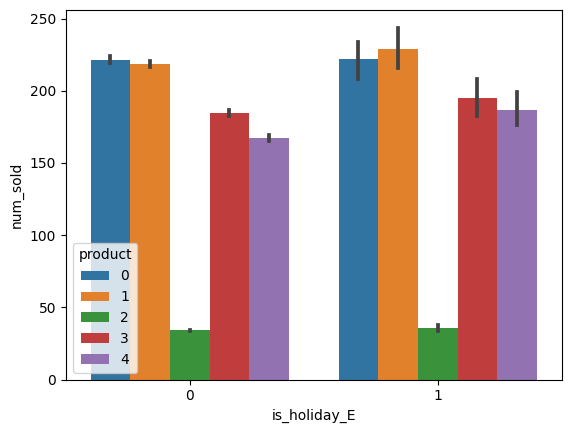

In [21]:
sns.barplot(x = 'is_holiday_E', y = 'num_sold', hue='product', data=train_df)

<Axes: xlabel='is_holiday_J', ylabel='num_sold'>

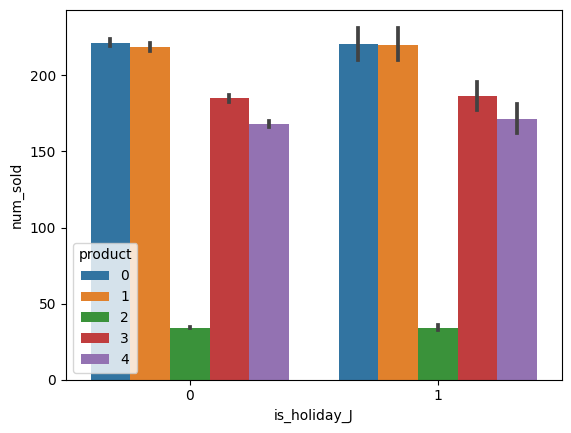

In [22]:
sns.barplot(x = 'is_holiday_J', y = 'num_sold', hue='product', data=train_df)

<Axes: xlabel='is_holiday_S', ylabel='num_sold'>

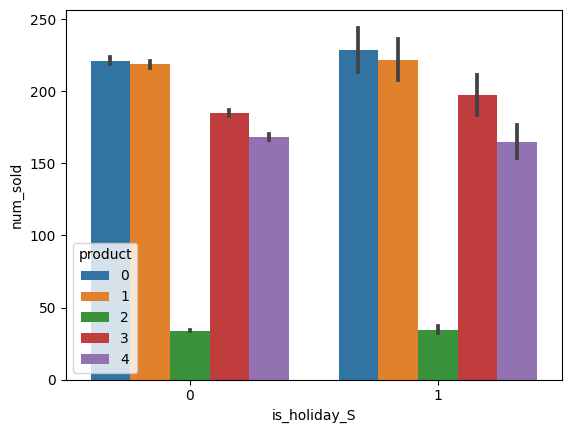

In [23]:
sns.barplot(x = 'is_holiday_S', y = 'num_sold', hue='product', data=train_df)

#all the plots show that holidays affect the num_sold, so creating Is_Holiday features was reasonable

In [10]:
train_df.head()

,id,country,store,product,num_sold,weekday,weekend,year,month,day,is_holiday_A,is_holiday_C,is_holiday_E,is_holiday_J,is_holiday_S
0,0,0,1,0,63,6,1,2017,1,1,1,1,1,1,0
1,1,0,1,1,66,6,1,2017,1,1,1,1,1,1,0
2,2,0,1,2,9,6,1,2017,1,1,1,1,1,1,0
3,3,0,1,3,59,6,1,2017,1,1,1,1,1,1,0
4,4,0,1,4,49,6,1,2017,1,1,1,1,1,1,0


In [11]:
#split train data into train set and validation set

from sklearn.model_selection import train_test_split

X = train_df.drop(["num_sold"], axis = 1)
y = train_df["num_sold"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


In [13]:
#check how various models perform on the set

from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models_pred = reg.fit(X_train, X_test, y_train, y_test)
print(models_pred)

 24%|███████████████████▌                                                              | 10/42 [01:43<09:07, 17.12s/it]

GaussianProcessRegressor model failed to execute
Unable to allocate 78.6 GiB for an array with shape (102712, 102712) and data type float64


 40%|█████████████████████████████████▏                                                | 17/42 [03:01<04:58, 11.94s/it]

KernelRidge model failed to execute
Unable to allocate 78.6 GiB for an array with shape (102712, 102712) and data type float64


 74%|████████████████████████████████████████████████████████████▌                     | 31/42 [18:28<11:36, 63.31s/it]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


 98%|████████████████████████████████████████████████████████████████████████████████  | 41/42 [33:18<01:27, 87.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 102712, number of used features: 14
[LightGBM] [Info] Start training from score 165.788184


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [33:19<00:00, 47.61s/it]

(                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
XGBRegressor                                 0.99       0.99  15.83   
RandomForestRegressor                        0.99       0.99  16.42   
LGBMRegressor                                0.99       0.99  17.23   
ExtraTreesRegressor                          0.99       0.99  17.28   
HistGradientBoostingRegressor                0.99       0.99  17.38   
BaggingRegressor                             0.99       0.99  17.42   
DecisionTreeRegressor                        0.98       0.98  22.52   
ExtraTreeRegressor                           0.98       0.98  23.26   
MLPRegressor                                 0.95       0.95  42.17   
GradientBoostingRegressor                    0.95       0.95  42.56   
KNeighborsRegressor                          0.91       0.91  56.43   
AdaBoostRegressor                            0.66       0.66 106.57   
NuSVR

In [ ]:
from xgboost import XGBRegressor

xgbreg = XGBRegressor()

xgbreg.fit(X_train, y_train)

y_pred = xgbreg.predict(test_df)